In [1]:
from utils_v1 import *


In [2]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import pathlib
import cv2
import sys
import numpy as np
from src import metrics as _metrics
import src.loss as loss
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MT, MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates


In [378]:
from enum import Enum
Predictor = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single')
# predictor = Predictor.pred_entropy
# predictor = Predictor.pred_var
# predictor = Predictor.MI
# predictor = Predictor.KL

predictor = Predictor.pred_entropy_single


In [4]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [5]:
training = False
save_probabilities = False
loadInference = False


addPastDeforestationInput = True
'''
if training == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if training == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = addPastDeforestationInput,
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = addPastDeforestationInput,
# 	borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()

inference_times = 10


if training == False:


	if type(dataset) == PAMultipleDates:
		# exp_ids = [103, 104, 105, 106, 107, 118, 119, 120, 121, 122] # same date
		exp_ids = [123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121] # earlier date

	if type(dataset) == MTMultipleDates:
		# exp_ids = [108, 109, 110, 111, 112, 113, 114, 115, 116, 117] # same date
		exp_ids = [130, 132, 133, 134, 135, 136, 137, 1125, 1124, 1123] # earlier date

else:
	# exp = 13 # Multiple dates. using fixed fixed past deforestation distance
	exp = 140

ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp_ids

[123, 124, 125, 126, 127, 128, 129, 131, 1122, 1121]

In [7]:
figures_path = 'output/figures' + dataset.__class__.__name__ + '/'
pathlib.Path(figures_path).mkdir(parents=True, exist_ok=True)
title_name = 'ResUnet'

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:
# Loading reference
label_mask = dataset.loadLabel()
print('Mask label shape: ', '\n', label_mask.shape, '\n', 'Unique values: ', '\n', np.unique(label_mask))

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [10]:
# np.save('label_not_independent.npy', label_mask)


In [11]:
# Creating tile mask

mask_tiles = create_mask(label_mask.shape[0], label_mask.shape[1], 
        grid_size=(dataset.grid_x, dataset.grid_y))
label_mask = label_mask[:mask_tiles.shape[0], :mask_tiles.shape[1]]

Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [12]:
label_mask.dtype

dtype('uint8')

In [13]:
label_mask_current_deforestation = dataset.getLabelCurrentDeforestation(
        label_mask)

In [14]:
label_mask.dtype

dtype('uint8')

In [15]:
# Loading image stack
image_stack = dataset.loadInputImage()

print('Image shape: ', image_stack.shape)
channels = image_stack.shape[-1]
image_stack = image_stack[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
print('mask: ',mask_tiles.shape)
print('image stack: ', image_stack.shape)
print('ref :', label_mask.shape)
#plt.imshow(mask_tiles)

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [16]:
np.unique(image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

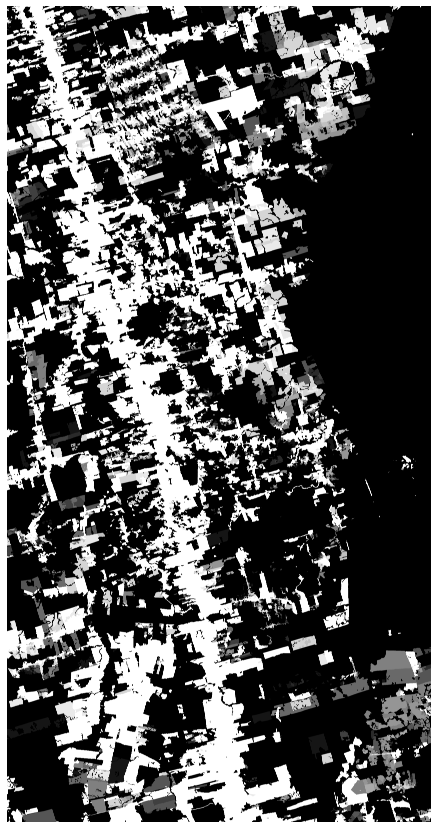

In [17]:


plt.figure(figsize=(15,15))
plt.imshow(image_stack[...,0], cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [18]:
ic(image_stack.shape)
channels = image_stack.shape[-1]
ic(channels)

ic| image_stack.shape: (17730, 9200, 21)
ic| channels: 21


21

In [19]:
mask_tr_val, mask_amazon_ts = dataset.getTrainValTestMasks(mask_tiles)


Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [20]:

patch_size = 128
if training == True:

    # Extracting patches from the idx matrix
    overlap = 0.7
    batch_size = 32
    im_idx = patchesHandler.create_idx_image(label_mask)


In [21]:
import importlib
if training == True:
	coords = patchesHandler.extract_patches(
		im_idx, patch_size=(patch_size, patch_size, 2), 
		overlap=overlap)

	coords_train, coords_val = patchesHandler.trainTestSplit(coords,
		mask_tr_val, patch_size=(patch_size, patch_size, 2))

	ic(coords_train.shape, coords_val.shape)
	# del im_idx

In [22]:
label_mask.shape

(17730, 9200, 1)

(-0.5, 9199.5, 17729.5, -0.5)

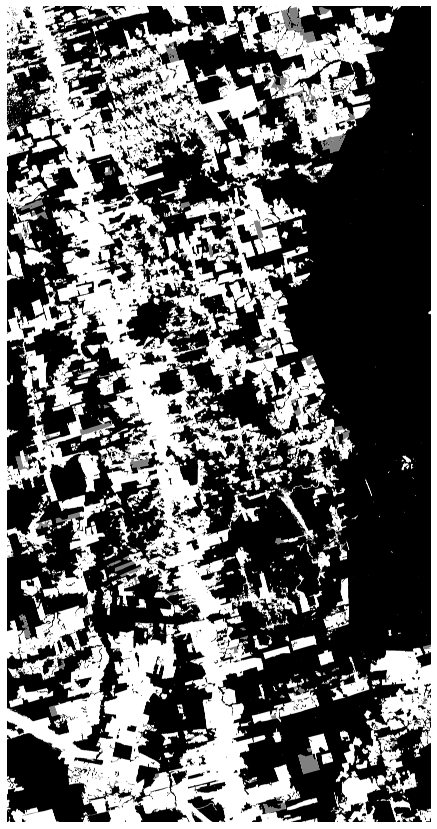

In [23]:

plt.figure(figsize=(15,15))
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    plt.imshow(label_mask[...,-1], cmap=plt.cm.gray)
else:
    plt.imshow(label_mask, cmap=plt.cm.gray)

# title_name = 'ResUnet'
plt.axis('off')
# plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [24]:
np.unique(label_mask)

array([0, 1, 2], dtype=uint8)

In [25]:
if training == True:
    print(coords_train)

In [26]:
if training == True:

    # Keeping patches with 2% of def class
    coords_train = patchesHandler.retrieve_idx_percentage(label_mask, coords_train, 
			patch_size, pertentage = 0.2)
    coords_val = patchesHandler.retrieve_idx_percentage(label_mask, coords_val, 
			patch_size, pertentage = 0.2)
    print('training samples: ', coords_train.shape, 
			'validation samples: ', coords_val.shape)


In [27]:
'''
import src.patchesHandler as sp
importlib.reload(sp)

patchesHandler = sp.PatchesHandlerMultipleDates(
		dataset)
'''

'\nimport src.patchesHandler as sp\nimportlib.reload(sp)\n\npatchesHandler = sp.PatchesHandlerMultipleDates(\n\t\tdataset)\n'

In [28]:
import src.plot as _plt
importlib.reload(_plt)

<module 'src.plot' from 'd:\\Jorge\\deforestation_uncertainty\\src\\plot.py'>

In [29]:
'''
if training == True:
    idx = 3100
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))
    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], 
            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],
            image_stack[...,[44,45,46]],            
            lims = None, 
            titles = ['2015', '2016', '2017', '2018', '2019'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False, False],
            invertMask = [False, False, False, False, False])
'''

"\nif training == True:\n    idx = 3100\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[4,5,6]]), np.mean(image_patch[...,[14,15,16]]))\n    _plt.plotCropSample5(image_stack[...,[4,5,6]], image_stack[...,[14,15,16]], \n            image_stack[...,[24,25,26]], image_stack[...,[34,35,36]],\n            image_stack[...,[44,45,46]],            \n            lims = None, \n            titles = ['2015', '2016', '2017', '2018', '2019'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False, False],\n            invertMask = [False, False, False, False, False])\n"

In [30]:
inputSnipShow = False

In [31]:
if training == True and inputSnipShow == True:
    idx = 2800
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [32]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [33]:
if training == True and inputSnipShow == True:

    idx = 97
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [34]:
if training == True and inputSnipShow == True:

    idx = 1200
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [35]:
inputSnipShow = False
if training == True and inputSnipShow == True:

    idx = 400
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])

In [36]:
'''
if training == True:

    idx = 6000
    print(coords_train[idx])
    image_patch, reference_patch = patchesHandler.getPatch(
        image_stack, label_mask, coords_train, idx = idx)
    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))
    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], 
            reference_patch, reference_patch,
            lims = None, 
            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],
            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],
            maskBackground = [False, False, False, False],
            invertMask = [False, False, False, False])
'''

"\nif training == True:\n\n    idx = 6000\n    print(coords_train[idx])\n    image_patch, reference_patch = patchesHandler.getPatch(\n        image_stack, label_mask, coords_train, idx = idx)\n    ic(np.mean(image_patch[...,[1,2,3]]), np.mean(image_patch[...,[11,12,13]]))\n    _plt.plotCropSample4(image_patch[...,[1,2,3]], image_patch[...,[11,12,13]], \n            reference_patch, reference_patch,\n            lims = None, \n            titles = ['Optical T0', 'Optical T1', 'Reference', 'Reference 2'],\n            cmaps = [plt.cm.gray, plt.cm.gray, plt.cm.gray, plt.cm.gray],\n            maskBackground = [False, False, False, False],\n            invertMask = [False, False, False, False])\n"

In [37]:
# Creating train and validation data generator
# importlib.reload(patchesHandler)
import pdb
if training == True:

	train_datagen = ImageDataGenerator()
	valid_datagen = ImageDataGenerator()
	# pdb.set_trace()
	len_X_train = coords_train.shape[0]
	len_X_valid = coords_val.shape[0]

	train_gen = train_datagen.flow(
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_train, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=True)
	# pdb.set_trace()

	valid_gen = valid_datagen.flow(
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1), 
			np.expand_dims(np.expand_dims(coords_val, axis = -1), axis = -1),
			batch_size=batch_size,
			shuffle=False)

	number_class = 3
	train_gen_batch = patchesHandler.batch_generator(train_gen,
			image_stack, label_mask, patch_size, number_class)
	valid_gen_batch = patchesHandler.batch_generator(valid_gen,
			image_stack, label_mask, patch_size, number_class)

	#del image_stack

In [38]:
# Creating folder for the experiment

# path_exp = dataset.paths.experiment + 'exp' + str(exp)
# path_models = path_exp+'/models'
# path_maps = path_exp+'/pred_maps'

# if not os.path.exists(path_exp):
#     os.makedirs(path_exp)   
# if not os.path.exists(path_models):
#     os.makedirs(path_models)   
# if not os.path.exists(path_maps):
#     os.makedirs(path_maps)
    
times = 1
method = 'resunet'
nb_filters = [16, 32, 64, 128, 256]
weights = [0.1, 0.9, 0]

In [39]:
if type(patchesHandler) == PatchesHandlerMultipleDates:
	channels = patchesHandler.input_image_shape

In [40]:
# path_exp

In [41]:
channels

21

In [42]:
image_stack.shape

(17730, 9200, 21)

In [43]:

metrics_all = []
if training == True:
    for tm in range(0,times):
        print('time: ', tm)

        rows = patch_size
        cols = patch_size
        adam = Adam(lr = 1e-3 , beta_1=0.9)
        
        loss = loss.weighted_categorical_crossentropy(weights)
        
        input_shape = (rows, cols, channels)
        model = build_resunet_dropout_spatial(input_shape, nb_filters, number_class)
        
        model.compile(optimizer=adam, loss=loss, metrics=['accuracy'])
        model.summary()

        earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
        checkpoint = ModelCheckpoint(path_models+ '/' + method +'_'+str(tm)+'.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        lr_reduce = ReduceLROnPlateau(factor=0.9, min_delta=0.0001, patience=5, verbose=1)
        callbacks_list = [earlystop, checkpoint]
        # train the model
        start_training = time.time()
        history = model.fit_generator(train_gen_batch,
                                steps_per_epoch=len_X_train*3//train_gen.batch_size,
                                validation_data=valid_gen_batch,
                                validation_steps=len_X_valid*3//valid_gen.batch_size,
                                epochs=100,
                                callbacks=callbacks_list)
        end_training = time.time() - start_training
        # metrics_all.append(end_training)
        del model

    # Saving training time
    # np.save(path_exp+'/metrics_tr.npy', metrics_all)
    del train_gen_batch, valid_gen_batch

In [44]:
if training == True:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('loss_history.png')

In [45]:
image_stack.shape

(17730, 9200, 21)

In [46]:
if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
    patchesHandler.dataset.image_channels[-1]

In [47]:
if type(dataset) == PAMultipleDates:
	channels = patchesHandler.input_image_shape
	image_stack = image_stack[..., patchesHandler.dataset.image_channels[-1]]
	label_mask = label_mask[...,-1]

In [48]:
image_stack.shape

(17730, 9200, 21)

In [49]:
#%% Test loop

metrics_ts = []
n_pool = 3
n_rows = 5
n_cols = 4
rows, cols = image_stack.shape[:2]
pad_rows = rows - np.ceil(rows/(n_rows*2**n_pool))*n_rows*2**n_pool
pad_cols = cols - np.ceil(cols/(n_cols*2**n_pool))*n_cols*2**n_pool
print(pad_rows, pad_cols)

npad = ((0, int(abs(pad_rows))), (0, int(abs(pad_cols))), (0, 0))
image1_pad = np.pad(image_stack, pad_width=npad, mode='reflect')
# del image_stack


-30.0 -16.0


In [50]:

h, w, c = image1_pad.shape
c = channels
patch_size_rows = h//n_rows
patch_size_cols = w//n_cols
num_patches_x = int(h/patch_size_rows)
num_patches_y = int(w/patch_size_cols)


class_n = 3

if loadInference == False:
    if save_probabilities == False:
        # prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, inference_times), dtype = np.float32)
        prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], inference_times), dtype = np.float32)

    new_model = utils_v1.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, c), 
        nb_filters = nb_filters, n_classes = class_n, dropout_seed = None, training = False)

    patchesHandler.class_n = class_n

    metrics_all =[]
    with tf.device('/cpu:0'):
        for tm in range(0,inference_times):
            print('time: ', tm)
            
            # Recinstructing predicted map
            start_test = time.time()

            path_exp = dataset.paths.experiment + 'exp' + str(exp_ids[tm])
            path_models = path_exp + '/models'
            # ic(path_models+ '/' + method +'_'+str(0)+'.h5')
            model = load_model(path_models+ '/' + method +'_'+str(0)+'.h5', compile=False)
            for l in range(1, len(model.layers)):
                new_model.layers[l].set_weights(model.layers[l].get_weights())
            
            '''
            args_network = {'patch_size_rows': patch_size_rows,
                'patch_size_cols': patch_size_cols,
                'c': c,
                'nb_filters': nb_filters,
                'class_n': class_n,
                'dropout_seed': inference_times}
            '''
            prob_reconstructed = patchesHandler.infer(
                    new_model, image1_pad, h, w, 
                    # model, image1_pad, h, w, 
                    num_patches_x, num_patches_y, patch_size_rows, 
                    patch_size_cols)
                    # patch_size_cols, a = args_network)
                    
            ts_time =  time.time() - start_test

            if save_probabilities == True:
                np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
            else:
                prob_rec[:,:,tm] = prob_reconstructed
            
            metrics_all.append(ts_time)
            del prob_reconstructed
        metrics_ = np.asarray(metrics_all)
        # Saving test time
        np.save(path_exp+'/metrics_ts.npy', metrics_)


time:  0
time:  1
time:  2
time:  3
time:  4
time:  5
time:  6
time:  7
time:  8
time:  9


In [51]:
'''
with tf.device('/cpu:0'):
    for tm in range(0,times):
        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) 
'''

"\nwith tf.device('/cpu:0'):\n    for tm in range(0,times):\n        np.save(path_maps+'/'+'prob_'+str(tm)+'.npy',prob_rec[:,:,tm]) \n"

In [52]:
del image1_pad


In [53]:
# if loadInference == True:
if save_probabilities == True:
    prob_rec = np.zeros((h, w, inference_times), dtype = np.float32)

    for tm in range(0, inference_times):
        print(tm)
        prob_rec[:,:,tm] = np.load(path_maps+'/'+'prob_'+str(tm)+'.npy').astype(np.float32)




In [54]:
# prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
prob_rec.shape



(17760, 9216, 10)

In [55]:
# prob_rec = np.transpose(prob_rec, (2, 0, 1))
# prob_rec = np.expand_dims(prob_rec, axis=-1)

In [56]:

if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))


In [57]:
prob_rec.shape

(17760, 9216, 10)

In [58]:
prob_rec.shape

(17760, 9216, 10)

In [59]:
mean_prob = np.mean(prob_rec, axis = -1)
# np.save(path_maps+'/prob_mean.npy', mean_prob)


In [60]:
ic(np.min(mean_prob), np.mean(mean_prob), np.max(mean_prob))

ic| np.min(mean_prob): 1.4644367e-15
    np.mean(mean_prob): 0.012334157
    np.max(mean_prob): 0.9999992


(1.4644367e-15, 0.012334157, 0.9999992)

In [61]:
ic(mean_prob.shape)

ic| mean_prob.shape: (17760, 9216)


(17760, 9216)

In [62]:
# Computing metrics over the test tiles
mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
'''
ref1 = np.ones_like(label_mask).astype(np.float32)

ref1 [label_mask == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = label_mask==1
'''


'\nref1 = np.ones_like(label_mask).astype(np.float32)\n\nref1 [label_mask == 2] = 0\nTileMask = mask_amazon_ts * ref1\nGTTruePositives = label_mask==1\n'

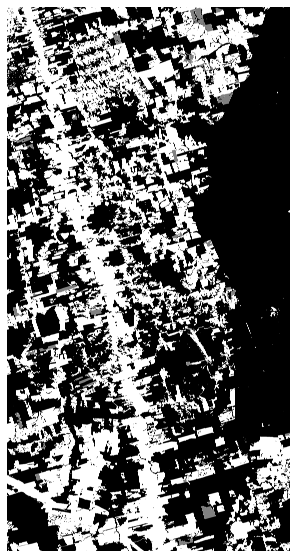

In [63]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [64]:
if issubclass(type(dataset), MultipleDates):
    label_mask = np.squeeze(label_mask)

In [65]:
mean_prob.shape

(17730, 9200)

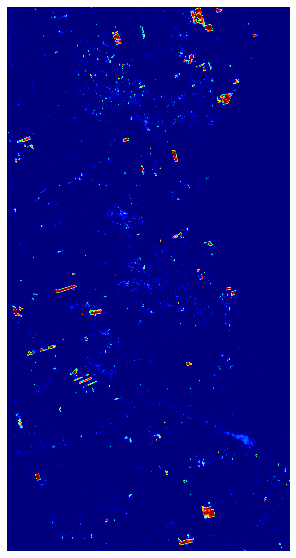

In [66]:
mean_prob = mean_prob.copy()
mean_prob[label_mask == 2] = 0
fig1 = plt.figure(figsize=(10,10))
plt.imshow(mean_prob, cmap = 'jet')
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [67]:
# print(np.unique(label_mask, return_counts=True))
print(label_mask.shape)

(17730, 9200)


In [68]:
label_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]
mean_prob_test = mean_prob_test[label_test != 2]
label_test = label_test[label_test != 2]

print(label_test.shape)
print(np.unique(label_test, return_counts=True))

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [69]:
from sklearn import metrics
mAP = round(metrics.average_precision_score(label_test, 
        mean_prob_test)*100, 2)
print(mAP)

88.42


In [70]:
from icecream import ic

ic(prob_rec.shape)
prob_rec = np.transpose(prob_rec, (2, 0, 1))


ic| prob_rec.shape: (17760, 9216, 10)


In [71]:
prob_rec = np.expand_dims(prob_rec, axis = -1)

In [72]:
ic(prob_rec.shape)

ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [73]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

epsilon = 1e-15
def show_im(im, ax, title = "", cmap = "jet"):
    im_plt = ax.imshow(im.astype(np.float32), cmap = cmap)
    plt.title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_plt, cax=cax) 

def get_mean(pred_probs):
      return np.mean(pred_probs, axis=0)
    
def get_uncertainty_var(pred_probs):
    return np.var(pred_probs, axis=0)
    
def predictive_variance(pred_probs):
    pred_var = get_uncertainty_var(pred_probs)
    pred_var = np.average(pred_var, axis = -1)
#    ic(pred_var.shape)
    return pred_var

def predictive_entropy(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    pred_entropy = np.zeros((pred_mean.shape[0:2]))

    K = pred_mean.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_mean[..., k] * np.log(pred_mean[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy


def single_experiment_entropy(pred_prob):
    pred_entropy = np.zeros(pred_prob.shape[0:2])
    ic(pred_entropy.shape)
    
    K = pred_prob.shape[-1]
    for k in range(K):
        pred_entropy = pred_entropy + pred_prob[..., k] * np.log(pred_prob[..., k] + epsilon) 
    pred_entropy = - pred_entropy / K
    return pred_entropy

def mutual_information(pred_probs):
    H = predictive_entropy(pred_probs)
    
    # sum_entropy = 0
    sum_entropy = np.zeros(pred_probs.shape[1:-1])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]
    ic(n, K)

    for i in range(n):
        for k in range(K):
            sum_entropy = sum_entropy + pred_probs[i, ..., k] * np.log(pred_probs[i, ..., k] + epsilon)

    sum_entropy = - sum_entropy / (n * K)

    MI = H - sum_entropy
    return MI


def expected_KL_divergence(pred_probs):
    pred_mean = get_mean(pred_probs) # shape (patch_len, patch_len, class_n)
    KL_divergence = np.zeros(pred_mean.shape[0:2])

    n = pred_probs.shape[0]
    K = pred_probs.shape[-1]

    for i in range(n):
        for k in range(K):
            # print(np.mean(pred_mean[..., k]), np.mean(pred_probs[i, ..., k]), np.mean(KL_divergence))
            # pdb.set_trace()
            KL_divergence += pred_mean[..., k] * np.log(pred_mean[..., k] / (pred_probs[i, ..., k] + epsilon) + epsilon)
    KL_divergence /= n
    return KL_divergence


In [74]:
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))
ic(prob_rec.shape)

ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.012330051
    np.max(prob_rec): 1.0
ic| prob_rec.shape: (10, 17760, 9216, 1)


(10, 17760, 9216, 1)

In [75]:
pred_entropy = predictive_entropy(prob_rec).astype(np.float32)

pred_entropy_single = single_experiment_entropy(prob_rec[0]).astype(np.float32)

pred_var = predictive_variance(prob_rec).astype(np.float32)

MI = mutual_information(prob_rec).astype(np.float32)



ic| pred_entropy.shape: (17760, 9216)
ic| n: 10, K: 1


In [76]:
KL = expected_KL_divergence(prob_rec).astype(np.float32)

In [77]:
np.mean(KL)

0.0035281242

In [78]:

pred_entropy_to_show = pred_entropy.copy()[:label_mask.shape[0], :label_mask.shape[1]]

pred_entropy_to_show[label_mask == 2] = 0


In [79]:
ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))
ic(pred_entropy.shape, pred_entropy_to_show.shape)

ic| np.min(pred_entropy_to_show): 0.0
    np.mean(pred_entropy_to_show): 0.009806012
    np.max(pred_entropy_to_show): 0.36787948
ic| np.min(pred_entropy): 4.9258988e-14
    np.mean(pred_entropy): 0.010970183
    np.max(pred_entropy): 0.36787948
ic| pred_entropy.shape: (17760, 9216)
    pred_entropy_to_show.shape: (17730, 9200)


((17760, 9216), (17730, 9200))

In [80]:
prob_rec.shape

(10, 17760, 9216, 1)

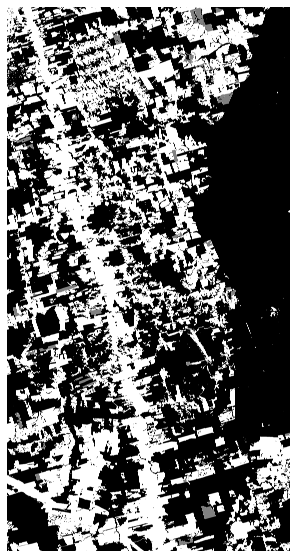

In [81]:
fig1 = plt.figure(figsize=(10,10))
plt.imshow(label_mask, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para prediction probability.png', dpi=150, bbox_inches='tight')

In [82]:
# Computing error mask
# label_mask
'''
for idx in range(10):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(prob_rec[idx], cmap = 'jet')
# fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')
'''

"\nfor idx in range(10):\n    fig, ax = plt.subplots(figsize=(10,10))\n    ax.set_xticks([])\n    ax.set_yticks([])\n    ax.imshow(prob_rec[idx], cmap = 'jet')\n# fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')\n"

(-0.5, 9199.5, 17729.5, -0.5)

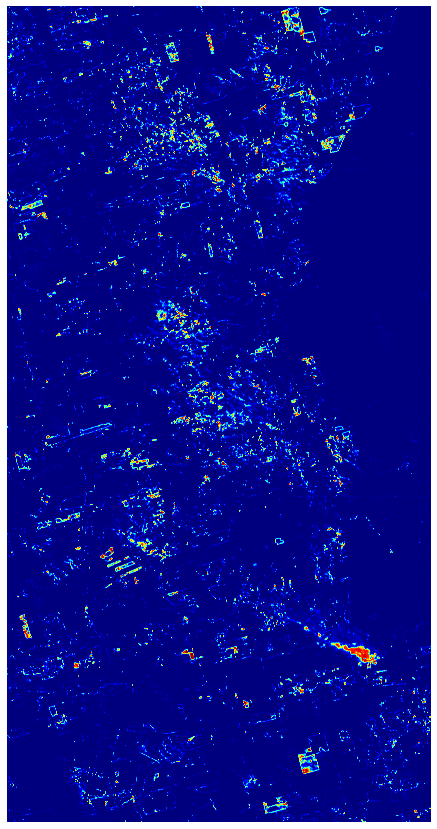

In [83]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
# show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
#plt.savefig('output/figures/Para' + title_name + ' uncertainty predictive entropy.png', 
 #   dpi=150, bbox_inches='tight')

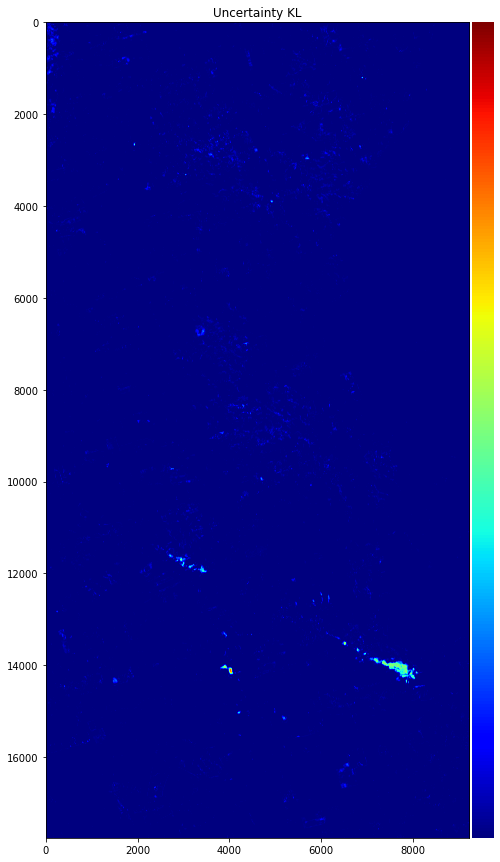

In [84]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
show_im(KL, ax, title = 'Uncertainty KL')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty KL.png', 
    dpi=150, bbox_inches='tight')

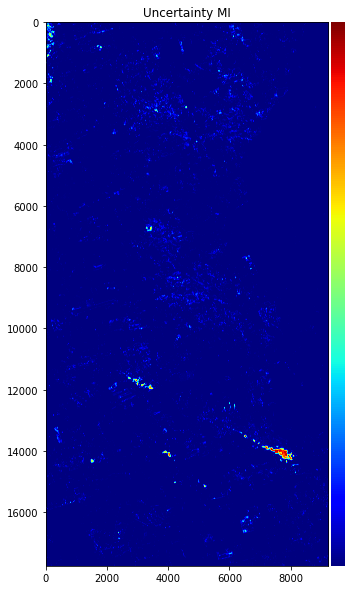

In [85]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty MI.png', 
    dpi=150, bbox_inches='tight')

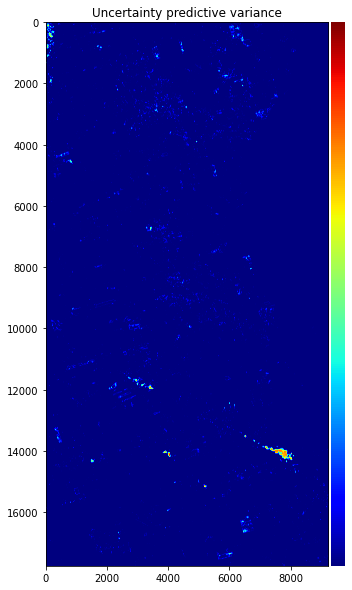

In [86]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_var, ax, title = 'Uncertainty predictive variance')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty Predictive variance.png', 
    dpi=150, bbox_inches='tight')

In [87]:
ic(pred_entropy.shape)


ic| pred_entropy.shape: (17760, 9216)


(17760, 9216)

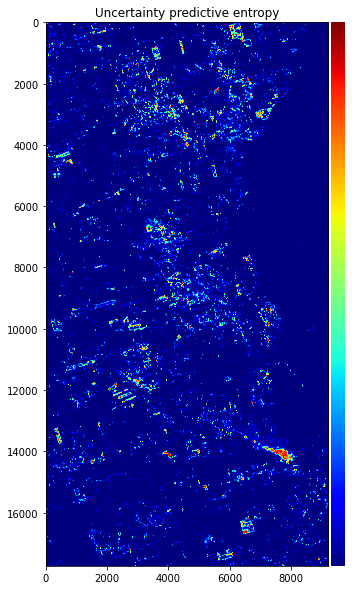

In [88]:

# pred_entropy_to_show = pred_entropy[:label_mask.shape[0], :label_mask.shape[1]].copy()

# ic(np.min(pred_entropy_to_show), np.mean(pred_entropy_to_show), np.max(pred_entropy_to_show))

# pred_entropy_to_show[label_mask == 2] = 0
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' uncertainty predictive entropy.png', 
    dpi=150, bbox_inches='tight')

In [89]:
ic(prob_rec.shape)
ic(np.min(prob_rec), np.mean(prob_rec), np.max(prob_rec))


ic| prob_rec.shape: (10, 17760, 9216, 1)
ic| np.min(prob_rec): 0.0
    np.mean(prob_rec): 0.012330051
    np.max(prob_rec): 1.0


(0.0, 0.012330051, 1.0)

In [90]:


'''
fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')
'''


"\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(pred_entropy_single, ax, title = 'Uncertainty predictive entropy single sample')\n"

In [91]:

'''
MI = mutual_information(prob_rec)

fig, ax = plt.subplots(1,1,figsize=(10,10))
show_im(MI, ax, title = 'Uncertainty MI')
'''


"\nMI = mutual_information(prob_rec)\n\nfig, ax = plt.subplots(1,1,figsize=(10,10))\nshow_im(MI, ax, title = 'Uncertainty MI')\n"

(array([0, 1, 2], dtype=uint8), array([81558000, 65246400, 16311600], dtype=int64))


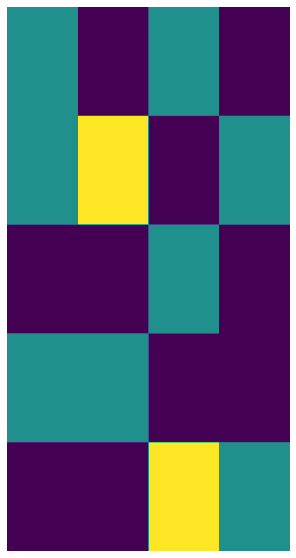

In [92]:
# mask_tr_val = test 0, train 1, val 2. 
# mask_ts = test 1.
print(np.unique(mask_tr_val, return_counts=True))
plt.figure(figsize=(10,10))
plt.imshow(mask_tr_val)
plt.axis('off')
plt.savefig('output/figures/Train val mask.png', dpi=200, bbox_inches='tight')



In [93]:
label_mask_current_deforestation = label_mask.copy()
label_mask_current_deforestation[label_mask_current_deforestation==2] = 0

In [94]:
label_mask_current_deforestation_to_show = label_mask_current_deforestation.copy()
label_mask_current_deforestation_to_show = np.abs(
        label_mask_current_deforestation_to_show - 1)
ic(np.unique(label_mask_current_deforestation_to_show, return_counts=True))

ic| np.unique(label_mask_current_deforestation_to_show, return_counts=True): (array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))


(array([  0, 255], dtype=uint8), array([  1838508, 161277492], dtype=int64))

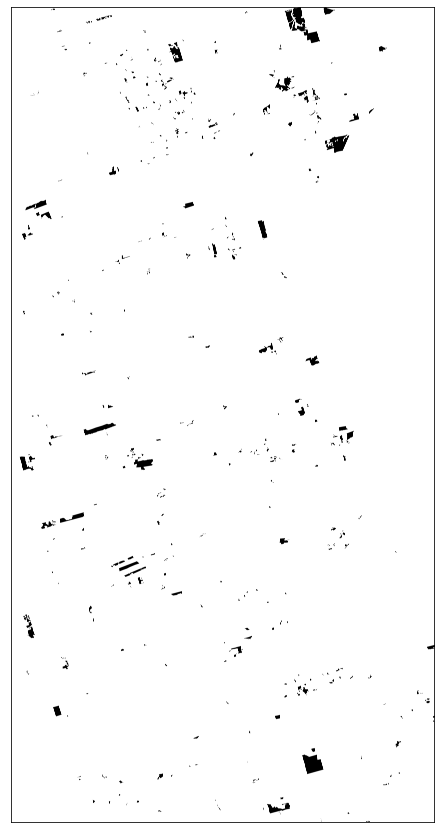

In [95]:
# Computing error mask
# label_mask

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(label_mask_current_deforestation_to_show, cmap = plt.cm.gray)
fig.savefig('output/figures/Para' + title_name + ' reference.png', dpi=300, bbox_inches='tight')




In [96]:


label_mask_val = label_mask[mask_tr_val == 2]
ic(label_mask_val.shape)

mean_prob_val = mean_prob[mask_tr_val == 2]

mean_prob_val = mean_prob_val[label_mask_val != 2]
label_mask_val_valid = label_mask_val[label_mask_val != 2]
ic(label_mask_val_valid.shape)



ic| label_mask_val.shape: (16311600,)
ic| label_mask_val_valid.shape: (9450701,)


(9450701,)

In [97]:
from sklearn import metrics
pos_label = 1
precision, recall, thresholds = metrics.precision_recall_curve(
            label_mask_val_valid, mean_prob_val, pos_label=pos_label)



In [98]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.405385, F-Score=0.824


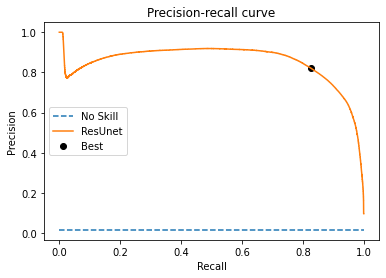

In [99]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(label_mask_val, precision, recall, ix)
plt.savefig('output/figures/' + 'Para_prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [379]:
print(mean_prob.shape)
predicted = np.zeros_like(mean_prob)
threshold = 0.5

if predictor != Predictor.pred_entropy_single:
    predicted[mean_prob>=threshold] = 1
    predicted[mean_prob<threshold] = 0
else:
    print("Single entropy")
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]>=threshold] = 1
    predicted[prob_rec[0][...,-1][:label_mask.shape[0], :label_mask.shape[1]]<threshold] = 0

print(np.unique(predicted, return_counts=True))

predicted_unpad = predicted.copy()
predicted_unpad[label_mask == 2] = 0
ic(predicted_unpad.shape, predicted.shape)
del predicted

(17730, 9200)
(array([0., 1.], dtype=float32), array([161675361,   1440639], dtype=int64))


ic| predicted_unpad.shape: (17730, 9200)
    predicted.shape: (17730, 9200)


In [380]:
threshold

0.5

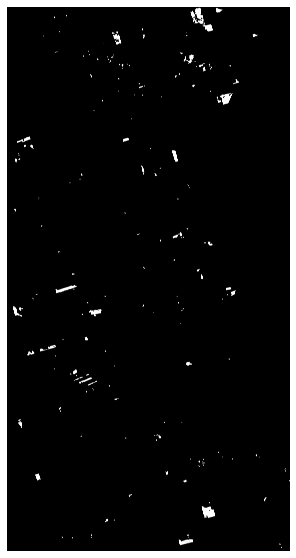

In [381]:

plt.figure(figsize=(10,10))
plt.imshow(predicted_unpad, cmap = plt.cm.gray)
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' predicted.png', dpi=150, bbox_inches='tight')


In [382]:

# mean_prob_unpad = mean_prob[:-npad[0][1], :-npad[1][1]]

In [383]:
# mean_prob_unpad.shape

In [384]:
# ic(mask_amazon_ts.shape)
# mask_amazon_ts = mask_amazon_ts[:-npad[0][1], :-npad[1][1]]


In [385]:
# ic(mask_amazon_ts.shape, predicted_unpad.shape)
# label_mask_current_deforestation = label_mask_current_deforestation[:-npad[0][1], :-npad[1][1]]

In [386]:
# label_mask = label_mask[:-npad[0][1], :-npad[1][1]]

In [387]:
import importlib
import utils_v1
importlib.reload(utils_v1)

<module 'utils_v1' from 'd:\\Jorge\\deforestation_uncertainty\\utils_v1.py'>

In [388]:
ic(predicted_unpad.shape, label_mask_current_deforestation.shape,
    mask_amazon_ts.shape, label_mask.shape, mean_prob.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask_current_deforestation.shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)
    mean_prob.shape: (17730, 9200)


((17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200), (17730, 9200))

In [389]:
# test metrics
from sklearn.metrics import f1_score

predicted_test = predicted_unpad[mask_amazon_ts == 1]
label_mask_current_deforestation_test = label_mask_current_deforestation[mask_amazon_ts == 1]
label_mask_test = label_mask[mask_amazon_ts == 1]
mean_prob_test = mean_prob[mask_amazon_ts == 1]

ic(predicted_test.shape)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        predicted_test, label_mask_test)
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        label_mask_current_deforestation_test, label_mask_test)
mean_prob_test = utils_v1.excludeBackgroundAreasFromTest(
        mean_prob_test, label_mask_test)

ic(predicted_test.shape)


ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54181542,)


(54181542,)

In [390]:
importlib.reload(_metrics)
removePolygons = True
if removePolygons == True:
    # remove polygons smaller than 625 px
    min_polygon_area = 625 # pixels

    predicted_unpad, label_mask = _metrics.removeSmallPolygonsForMetrics(predicted_unpad, label_mask,
        min_polygon_area)
    predicted_masked, label_masked = _metrics.getTest(predicted_unpad, label_mask, mask_amazon_ts)

    predicted_test = predicted_masked
    label_mask_current_deforestation_test = label_masked


ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161789622,   1326378], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161789622,   1326378], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0.], dtype=float32), array([163116000], dtype=int64))
ic| predicted.shape: (17730, 9200), label_mask.shape: (17730, 9200)
ic| predicted_masked.shape: (81558000,)
    label_masked.shape: (81558000,)
ic| np.unique(label_masked, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                  array([53440696,   740846, 27376458], dtype=int64))
ic| predicted_masked.shape: (54181542,)
    label_masked.shape: (54181542,)


In [391]:

deforestationMetricsGet = True
if deforestationMetricsGet == True:
        f1 = round(f1_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        precision = round(precision_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        recall = round(recall_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        oa = round(accuracy_score(label_mask_current_deforestation_test, predicted_test)*100, 2)
        if removePolygons == False:
                mAP = round(metrics.average_precision_score(label_mask_current_deforestation_test, 
                        mean_prob_test)*100, 2)
        else:
                '''
                # Computing metrics over the test tiles
                # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
                ref1 = np.ones_like(label_mask).astype(np.float32)

                ref1 [label_mask == 2] = 0
                TileMask = mask_amazon_ts * ref1
                GTTruePositives = label_mask==1

                # Metrics for th=0.5    

                Npoints = 50
                Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
                ProbList = np.linspace(Pmax,0,Npoints)

                metrics_ = matrics_AA_recall(ProbList, mean_prob, label_mask, mask_amazon_ts, 625)
                print('Metrics th = 0.5: ', metrics_*100)
                '''
                pass


In [392]:
ic(f1, precision, recall)
# ic(f1, precision, recall)


ic| f1: 81.41, precision: 97.07, recall: 70.1


(81.41, 97.07, 70.1)

In [393]:
ic(oa)

ic| oa: 99.56


99.56

### Metrics for validation set in forest/deforestation detection

In [394]:
ic(mask_tr_val.shape)

ic| mask_tr_val.shape: (17730, 9200)


(17730, 9200)

In [395]:
predicted_val = predicted_unpad[mask_tr_val == 2]
predicted_val = predicted_val[label_mask_val != 2]

In [396]:

f1_val = round(f1_score(label_mask_val_valid, predicted_val)*100, 2)
precision_val = round(precision_score(label_mask_val_valid, predicted_val)*100, 2)
recall_val = round(recall_score(label_mask_val_valid, predicted_val)*100, 2)

mAP_val = round(metrics.average_precision_score(label_mask_val_valid, mean_prob_val)*100, 2)


ic(f1_val, precision_val, recall_val, mAP_val)

ic| f1_val: 82.21
    precision_val: 89.56
    recall_val: 75.98
    mAP_val: 85.22


(82.21, 89.56, 75.98, 85.22)

In [397]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    # Computing metrics over the test tiles
    # mean_prob = mean_prob[:label_mask.shape[0], :label_mask.shape[1]]
    ref1 = np.ones_like(label_mask).astype(np.uint8)

    ref1 [label_mask == 2] = 0
    TileMask = mask_amazon_ts * ref1
    GTTruePositives = label_mask==1

    # Metrics for th=0.5    

    ProbList_05 = [0.5]

    metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
    print('Metrics th = 0.5: ', metrics_05*100)


In [398]:

error_mask = np.abs(predicted_unpad - label_mask_current_deforestation)
print(np.unique(error_mask, return_counts=True))


(array([0., 1.], dtype=float32), array([162427946,    688054], dtype=int64))


In [399]:
false_positive_mask = predicted_unpad - label_mask_current_deforestation
ic(false_positive_mask.shape)
ic(np.unique(false_positive_mask, return_counts=True))
# 0 class 0, 1 class 1, 2 false positive, 3 false negative
# colormap black, white, blue, red.



ic| false_positive_mask.shape: (17730, 9200)
ic| np.unique(false_positive_mask, return_counts=True): (array([-1.,  0.,  1.], dtype=float32),
                                                         array([   600092, 162427946,     87962], dtype=int64))


(array([-1.,  0.,  1.], dtype=float32),
 array([   600092, 162427946,     87962], dtype=int64))

In [400]:
ic(predicted_unpad.shape, label_mask.shape)

ic| predicted_unpad.shape: (17730, 9200)
    label_mask.shape: (17730, 9200)


((17730, 9200), (17730, 9200))

In [401]:

importlib.reload(_metrics)

prediced_unpad_to_show = predicted_unpad.copy()
prediced_unpad_to_show[label_mask == 2] = 0

error_mask_to_show = _metrics.getRgbErrorMask(prediced_unpad_to_show, 
        label_mask_current_deforestation).astype(np.uint8)
error_mask_to_show_rgb = _metrics.saveRgbErrorMask(error_mask_to_show).astype(np.uint8)
del error_mask_to_show
cv2.imwrite('output/figures/Para_error_mask_to_show_rgb.png', error_mask_to_show_rgb)

# ,
#        dim = (617, 1162)


True

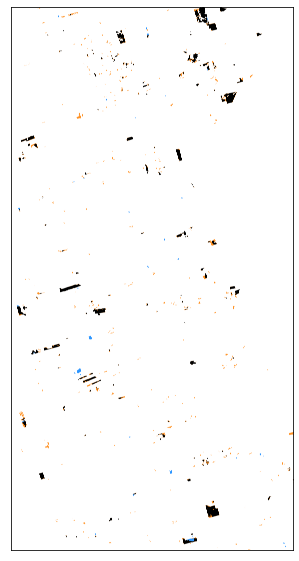

In [402]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_xticks([])
ax.set_yticks([])

ax.imshow(error_mask_to_show_rgb[...,::-1])

fig.savefig('output/figures/Para' + title_name + ' error mask color.png', dpi=300, bbox_inches='tight')


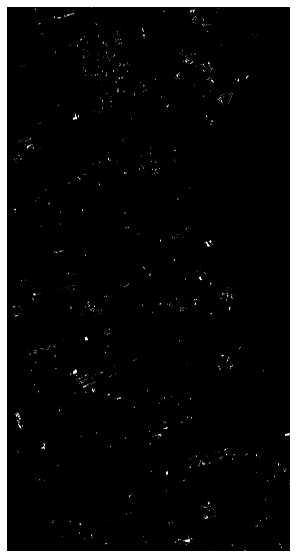

In [403]:
plt.figure(figsize=(10,10))
plt.imshow(error_mask, cmap=plt.cm.gray)
title_name = 'ResUnet'
plt.axis('off')
plt.savefig('output/figures/Para' + title_name + ' error mask.png', dpi=150, bbox_inches='tight')

In [404]:
ic(label_mask.shape)
ic(mask_amazon_ts.shape)
 
label_mask_test = utils_v1.getTestVectorFromIm(
        label_mask, mask_amazon_ts)        
ic(label_mask_test.shape)

error_mask_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_amazon_ts),
        label_mask_test) 


error_mask_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
        error_mask, mask_tr_val, mask_return_value = 2),
        label_mask_val) 

 
ic(error_mask_test.shape)

ic| label_mask.shape: (17730, 9200)
ic| mask_amazon_ts.shape: (17730, 9200)
ic| label_mask_test.shape: (81558000,)
ic| error_mask_test.shape: (54181542,)


(54181542,)

In [405]:
# ic(pred_entropy[:-npad[0][1], :-npad[1][1]][:-npad[0][1], :-npad[1][1]].shape)

In [406]:
     

ic(pred_entropy.shape, utils_v1.unpadIm(pred_entropy, npad).shape, 
    mask_amazon_ts.shape, label_mask_test.shape)
pred_entropy_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_amazon_ts),
        label_mask_test)
  
pred_var_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_amazon_ts),
        label_mask_test)

MI_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_amazon_ts),
        label_mask_test)

KL_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_amazon_ts),
        label_mask_test)


ic| pred_entropy.shape: (17760, 9216)
    utils_v1.unpadIm(pred_entropy, npad).shape: (17730, 9200)
    mask_amazon_ts.shape: (17730, 9200)
    label_mask_test.shape: (81558000,)


In [407]:
pred_entropy_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

pred_var_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_var, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

MI_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(MI, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

KL_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(KL, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)


In [408]:
pred_entropy_single_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_amazon_ts),
        label_mask_test)

pred_entropy_single_val = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                utils_v1.unpadIm(pred_entropy_single, npad), mask_tr_val, mask_return_value = 2),
        label_mask_val)

        

In [409]:
# dataset.previewLims1 = np.array([2200, 3200, 6900, 7900])
# dataset.previewLims2 = np.array([500, 1500, 3500, 4500])
# dataset.previewBands = [2, 1, 0] 

In [410]:


# dataset.previewLims1 = np.array([7600, 8600, 4500, 5500])
# dataset.previewLims1 = np.array([12200, 13200, 200, 1200])
# dataset.previewLims1 = np.array([11800, 12800, 9000, 10000])

# dataset.previewLims1 = np.array([11500, 12500, 9000, 10000])

# dataset.previewLims2 = np.array([5000, 6000, 9500, 10500])

ic(dataset.previewLims1, dataset.previewLims2)
lims = dataset.previewLims1
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))
lims = dataset.previewLims2
ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
ic(mask_amazon_ts.shape)


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| mask_amazon_ts.shape: (17730, 9200)


(17730, 9200)

In [411]:
uncertainty_vlims = [np.min(pred_entropy_to_show), np.max(pred_entropy_to_show)]


ic| dataset.previewLims1: array([2200, 3200, 6900, 7900])
    dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


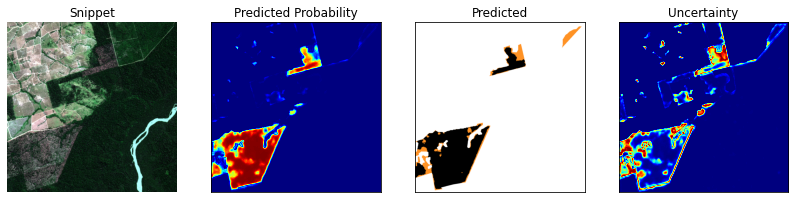

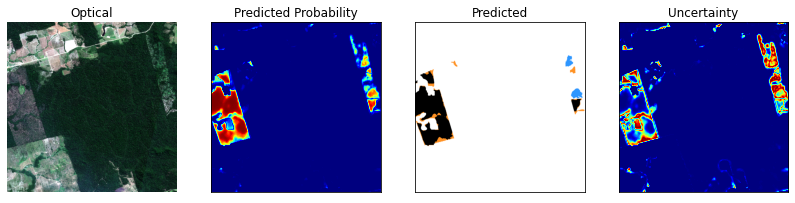

In [412]:


plotCropSampleFlag = True
if plotCropSampleFlag == True:
        importlib.reload(_metrics)
        # import matplotlib
        # customCmap = matplotlib.colors.ListedColormap(['black', 'red'])
        ic(dataset.previewLims1, dataset.previewLims2)
        lims = dataset.previewLims1
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]))
        lims = dataset.previewLims2
        ic(np.unique(mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True))

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims1, 
                titles = ['Snippet', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty1.png', dpi=150, bbox_inches='tight')

        _plt.plotCropSample4(image_stack[...,dataset.previewBands], mean_prob, 
                error_mask_to_show_rgb[...,::-1], pred_entropy_to_show, 
                lims = dataset.previewLims2, 
                titles = ['Optical', 'Predicted Probability', 'Predicted', 'Uncertainty'],
                cmaps = [plt.cm.gray, 'jet', plt.cm.gray, 'jet'],
                maskBackground = [False, True, False, True],
                invertMask = [False, False, False, False], uncertainty_vlims = uncertainty_vlims)
        plt.savefig('output/figures/' + dataset.__class__.__name__ + 'PredictSampleUncertainty2.png', dpi=150, bbox_inches='tight')

In [413]:

if predictor == Predictor.pred_var:
    uncertainty = pred_var_test
    uncertainty_val = pred_var_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Variance'
    best_threshold = 0.2
elif predictor == Predictor.MI:
    uncertainty = MI_test
    uncertainty_val = MI_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Mutual Information'
    best_threshold = 0.2
elif predictor == Predictor.pred_entropy:
    uncertainty = pred_entropy_test
    uncertainty_val = pred_entropy_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287
elif predictor == Predictor.KL:
    uncertainty = KL_test
    uncertainty_val = KL_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy'
    best_threshold = 0.287

elif predictor == Predictor.pred_entropy_single:
    uncertainty = pred_entropy_single_test
    uncertainty_val = pred_entropy_single_val
    plot_lims = [[0, 0.38], [0, 2500]]
    title_name = 'Predictive Entropy Single'
    best_threshold = 0.287


In [414]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))
ic(np.min(pred_entropy), np.mean(pred_entropy), np.max(pred_entropy))


ic| np.min(uncertainty): -1.4320656e-07
    np.mean(uncertainty): 0.00467207
    np.max(uncertainty): 1.1609454
ic| np.min(pred_entropy): 4.9258988e-14
    np.mean(pred_entropy): 0.010970183
    np.max(pred_entropy): 0.36787948


(4.9258988e-14, 0.010970183, 0.36787948)

In [415]:

y_test = error_mask_test
y_val = error_mask_val

ic(y_test.shape, uncertainty.shape)
pos_label = 1
ROCmode = 'val'
if ROCmode == 'test':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, uncertainty, pos_label=pos_label)
elif ROCmode == 'val':
    fpr, tpr, thresholds = metrics.roc_curve(y_val, uncertainty_val, pos_label=pos_label)

roc_auc = metrics.auc(fpr, tpr)
ic(roc_auc)

ic| y_test.shape: (54181542,), uncertainty.shape: (54181542,)
ic| roc_auc: 0.8966368118196827


0.8966368118196827

Best Threshold=0.003568, G-Mean=0.873


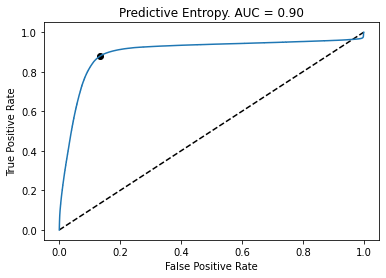

In [416]:
importlib.reload(_metrics)
plt.figure()
_metrics.plotAUC(fpr, tpr, roc_auc, modelId = title_name)
ix, best_threshold_uncertainty = _metrics.getBestThresholdGMean(fpr, tpr, thresholds)
# ix, best_threshold_uncertainty = _metrics.getBestThresholdJStatistic(fpr, tpr, thresholds)

_metrics.plotBestThreshold(fpr, tpr, ix)
plt.savefig(figures_path + title_name + ' roc_curve.png', dpi=200)

In [417]:
np.set_printoptions(suppress=False)
ic(best_threshold_uncertainty)
np.set_printoptions(suppress=True)


ic| best_threshold_uncertainty: 0.0035680342


In [418]:
# best_threshold_uncertainty = 0.262948
# best_threshold_uncertainty = 0.08329400420188904

In [419]:
# threshold = 0.003254
y_pred_thresholded = np.zeros_like(uncertainty)
y_pred_thresholded[uncertainty >= best_threshold_uncertainty] = 1


In [420]:
metrics_error_detection = False
if metrics_error_detection == True:
    f1 = round(f1_score(error_mask_test, y_pred_thresholded)*100, 2)
    precision = round(metrics.precision_score(error_mask_test, y_pred_thresholded)*100, 2)
    recall = round(metrics.recall_score(error_mask_test, y_pred_thresholded)*100, 2)
    ic(f1, precision, recall)

    cm = metrics.confusion_matrix(error_mask_test, y_pred_thresholded)
    print(cm)

In [421]:
if metrics_error_detection == True:

    ic(best_threshold_uncertainty)

In [422]:
if metrics_error_detection == True:

    predicted_error_mask = np.zeros(pred_entropy.shape, dtype = np.uint8)
    predicted_error_mask[pred_entropy>=best_threshold_uncertainty] = 1
    predicted_error_mask = utils_v1.unpadIm(predicted_error_mask, npad)

    predicted_error_mask[label_mask == 2] = 0

In [423]:
if metrics_error_detection == True:

    # ic(np.unique(predicted_error_mask, return_counts=True))
    # ic(np.unique(error_mask, return_counts=True))
    predicted_error_mask_to_show = predicted_error_mask.copy()
    predicted_error_mask_to_show = np.abs(1 - predicted_error_mask_to_show)
    predicted_error_mask_to_show = predicted_error_mask_to_show.astype(np.uint8)*255
    predicted_error_mask_to_show = np.repeat(
        np.expand_dims(predicted_error_mask_to_show, axis=-1),
        3, axis = -1)
    fig, ax = plt.subplots(figsize=(15,15))
    ax.set_xticks([])
    ax.set_yticks([])

    ax.imshow(predicted_error_mask_to_show)


    title_name = 'ResUnet'
    fig.savefig('output/figures/Para' + title_name + 'predicted error mask.png', dpi=300, bbox_inches='tight')


In [424]:
if metrics_error_detection == True:

    predicted_error_mask_forest = predicted_error_mask.copy()
    predicted_error_mask_forest[predicted_unpad == 1] = 0
    ic(np.unique(predicted_unpad, return_counts=True))
    ic(np.unique(predicted_error_mask_forest, return_counts=True))

    plt.figure(figsize=(10,10))
    plt.imshow(predicted_error_mask, cmap=plt.cm.gray)
    title_name = 'ResUnet'
    plt.axis('off')
    plt.savefig('output/figures/Para' + title_name + 'predicted error mask forest.png', dpi=150, bbox_inches='tight')


In [425]:
if metrics_error_detection == True:

        importlib.reload(_metrics)
        _metrics.plotConfusionMatrix(cm)
        plt.savefig(figures_path + title_name + ' confusion matrix ROC threshold.png', 
                dpi=200, bbox_inches='tight')

In [426]:
label_mask_current_deforestation_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                label_mask_current_deforestation, mask_amazon_ts),
        label_mask_test)

predicted_test = utils_v1.excludeBackgroundAreasFromTest(
        utils_v1.getTestVectorFromIm(
                predicted_unpad, mask_amazon_ts),
        label_mask_test)
        


Get precision-recall threshold

In [427]:
precision, recall, thresholds = metrics.precision_recall_curve(
            y_val, uncertainty_val, pos_label=pos_label)



In [428]:
ic(thresholds)

ic| thresholds: array([-0.00000011, -0.00000011, -0.00000011, ...,  0.6619668 ,
                        0.66623616,  0.68409467], dtype=float32)


array([-0.00000011, -0.00000011, -0.00000011, ...,  0.6619668 ,
        0.66623616,  0.68409467], dtype=float32)

In [429]:
fscore = (2 * precision * recall) / (precision + recall)
ix = np.nanargmax(fscore)
best_threshold_uncertainty = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.056012, F-Score=0.186


C:\Users\jchamorro\AppData\Local\Temp\ipykernel_11688\3129774117.py:1: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


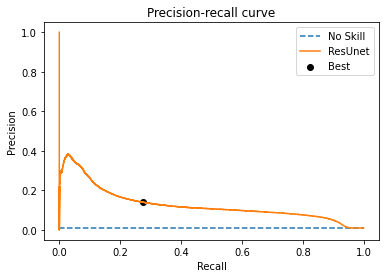

In [430]:
importlib.reload(_metrics)
_metrics.plotPrecisionRecall(y_val, precision, recall, ix)
plt.savefig('output/figures/' + 'Para' + 'prediction_recall_curve.png', dpi=150, bbox_inches='tight')

In [431]:
'''
# Metrics for th=0.5    
ProbList_05 = [0.5]

metrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)
print('Metrics th = 0.5: ', metrics_05*100)
'''


"\n# Metrics for th=0.5    \nProbList_05 = [0.5]\n\nmetrics_05 = matrics_AA_recall(ProbList_05, mean_prob, label_mask, mask_amazon_ts, 625)\nprint('Metrics th = 0.5: ', metrics_05*100)\n"

In [432]:
ic(np.min(uncertainty), np.average(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -1.4320656e-07
    np.average(uncertainty): 0.00467207
    np.max(uncertainty): 1.1609454


(-1.4320656e-07, 0.00467207, 1.1609454)

In [433]:
# plt.hist(uncertainty)

In [434]:
ic(uncertainty.dtype, label_mask_current_deforestation_test.dtype, predicted_test.dtype)

ic| uncertainty.dtype: dtype('float32')
    label_mask_current_deforestation_test.dtype: dtype('uint8')
    predicted_test.dtype: dtype('float32')


(dtype('float32'), dtype('uint8'), dtype('float32'))

In [435]:
ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
ic(np.unique(label_mask_current_deforestation_test))

ic| uncertainty.shape: (54181542,)
    label_mask_current_deforestation_test.shape: (54181542,)
ic| np.unique(label_mask_current_deforestation_test): array([0, 1], dtype=uint8)


array([0, 1], dtype=uint8)

In [436]:
ic(np.min(uncertainty), np.mean(uncertainty), np.max(uncertainty))

ic| np.min(uncertainty): -1.4320656e-07
    np.mean(uncertainty): 0.00467207
    np.max(uncertainty): 1.1609454


(-1.4320656e-07, 0.00467207, 1.1609454)

In [437]:
importlib.reload(_metrics)

threshold_uncertainty = 0.15

predicted_thresholded = np.zeros_like(uncertainty).astype(np.int8)
predicted_thresholded[uncertainty >= threshold_uncertainty] = 1
predicted_thresholded = predicted_thresholded.astype(np.uint8)
ic(predicted_thresholded.shape)


ic| predicted_thresholded.shape: (54181542,)


(54181542,)

In [438]:
ic(np.unique(predicted_thresholded, return_counts=True),
    np.unique(label_mask, return_counts=True),
    np.unique(mask_amazon_ts, return_counts=True))



ic| np.unique(predicted_thresholded, return_counts=True): (array([0, 1], dtype=uint8), array([53938691,   242851], dtype=int64))
    np.unique(label_mask, return_counts=True): (array([0, 1, 2], dtype=uint8),
                                                array([100840039,   1787806,  60488155], dtype=int64))
    np.unique(mask_amazon_ts, return_counts=True): (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64))


((array([0, 1], dtype=uint8), array([53938691,   242851], dtype=int64)),
 (array([0, 1, 2], dtype=uint8),
  array([100840039,   1787806,  60488155], dtype=int64)),
 (array([0, 1], dtype=uint8), array([81558000, 81558000], dtype=int64)))

In [439]:
def getUncertaintyPercentageFromTest(uncertainty_mask, 
        label_mask, mask_test):
    total_test_area = mask_test.copy()
    total_test_area[label_mask == 2] = 0

    percentage = np.count_nonzero(uncertainty_mask.flatten()) / np.count_nonzero(total_test_area.flatten())
    return total_test_area, percentage

total_test_area, percentage = getUncertaintyPercentageFromTest(predicted_thresholded, 
        label_mask, mask_amazon_ts)

ic(percentage)

ic| percentage: 0.004482172175904481


0.004482172175904481

In [440]:
AA = np.count_nonzero(predicted_thresholded.flatten()) / len(label_mask_current_deforestation_test)
ic(AA)

# metrics_values = _metrics.getAA_Recall(uncertainty, 
#                 label_mask_current_deforestation_test, 
#                 predicted_test, [threshold_uncertainty])


ic| AA: 0.004482172175904481


0.004482172175904481

In [441]:
predictor

<Predictor.KL: 4>

In [442]:

importlib.reload(_metrics)

# threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
if predictor == Predictor.pred_entropy:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.pred_var:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.13/0.36 for x in threshold_list] + [np.max(uncertainty)-0.0015, np.max(uncertainty)-0.0008]
elif predictor == Predictor.MI:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*0.235/0.36 for x in threshold_list] + [np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
elif predictor == Predictor.KL:
        threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                0.25, 0.27, 0.3, 0.34, 0.36]
        threshold_list = [x*1.0/0.36 for x in threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                
        # threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
print(threshold_list)
loadThresholdMetrics = False
if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metrics_values = _metrics.getAA_Recall(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        # ic(metrics_values)


ic| uncertainty.shape: (54181542,)
    label_mask_current_deforestation_test.shape: (54181542,)


[0.006944444444444445, 0.01388888888888889, 0.020833333333333332, 0.02777777777777778, 0.041666666666666664, 0.06944444444444445, 0.1388888888888889, 0.22222222222222224, 0.2777777777777778, 0.4166666666666667, 0.5555555555555556, 0.625, 0.6944444444444444, 0.7500000000000001, 0.8333333333333334, 0.9444444444444445, 1.0, 1.1549454154968262, 1.1579454154968263]
threshold 0.006944444444444445
(49894025,) (49894025,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4287517,)
    predicted_test_classified_incorrect.shape: (4287517,)


cm_correct [[49493355     1403]
 [   24322   374945]]


ic| TP_H + FN_H + FP_H + TN_H: 4287517
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 4287517
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[3931669   14269]
 [ 197217  144362]]
[0.99627207 0.93908337 0.50610383 0.07913243 0.91004911 0.42263137]
threshold 0.01388888888888889
(51304225,) (51304225,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2877317,)
    predicted_test_classified_incorrect.shape: (2877317,)


cm_correct [[50805480     3908]
 [   60537   434300]]


ic| TP_H + FN_H + FP_H + TN_H: 2877317
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2877317
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[2619544   11764]
 [ 161002   85007]]
[0.99108186 0.87766275 0.5862217  0.05310511 0.87843466 0.34554427]
threshold 0.020833333333333332
(52072011,) (52072011,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2109531,)
    predicted_test_classified_incorrect.shape: (2109531,)


cm_correct [[51506536     5788]
 [   93346   466341]]


ic| TP_H + FN_H + FP_H + TN_H: 2109531
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2109531
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[1918488    9884]
 [ 128193   52966]]
[0.98774064 0.83321749 0.6294709  0.0389345  0.84273667 0.292373  ]
threshold 0.02777777777777778
(52563219,) (52563219,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1618323,)
    predicted_test_classified_incorrect.shape: (1618323,)
ic

cm_correct [[51953123     7343]
 [  118483   484270]]
cm_incorrect [[1471901    8329]
 [ 103056   35037]]


| TP_H + FN_H + FP_H + TN_H: 1618323
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1618323
    len(label_mask_current_deforestation_test): 54181542


[0.98506345 0.80343026 0.65367161 0.02986853 0.80793709 0.25372032]
threshold 0.041666666666666664
(53135142,) (53135142,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1046400,)
    predicted_test_classified_incorrect.shape: (1046400,)
ic| TP_H + FN_H + FP_H + TN_H: 1046400
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1046400
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52468351     9726]
 [  153847   503218]]
cm_incorrect [[956673   5946]
 [ 67692  16089]]
[0.98103887 0.76585726 0.67924778 0.01931285 0.73015657 0.19203638]
threshold 0.06944444444444445
(53618027,) (53618027,)


ic| label_current_deforestation_test_classified_incorrect.shape: (563515,)
    predicted_test_classified_incorrect.shape: (563515,)
ic| TP_H + FN_H + FP_H + TN_H: 563515
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 563515
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52901003    12452]
 [  189186   515386]]
cm_incorrect [[524021   3220]
 [ 32353   3921]]
[0.97640943 0.73148805 0.69567224 0.0104005  0.54908276 0.10809395]
threshold 0.1388888888888889
(53921405,) (53921405,)


ic| label_current_deforestation_test_classified_incorrect.shape: (260137,)
    predicted_test_classified_incorrect.shape: (260137,)
ic| TP_H + FN_H + FP_H + TN_H: 260137
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 260137
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53173321    14965]
 [  214081   519038]]
cm_incorrect [[251703    707]
 [  7458    269]]
[0.97197581 0.70798602 0.70060174 0.00480121 0.27561475 0.03481299]
threshold 0.22222222222222224
(53998510,) (53998510,)


ic| label_current_deforestation_test_classified_incorrect.shape: (183032,)
    predicted_test_classified_incorrect.shape: (183032,)
ic| TP_H + FN_H + FP_H + TN_H: 183032
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 183032
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53243682    15605]
 [  220007   519216]]
cm_incorrect [[181342     67]
 [  1532     91]]
[0.97082201 0.70238074 0.70084201 0.00337812 0.57594937 0.05606901]
threshold 0.2777777777777778
(54023007,) (54023007,)


ic| label_current_deforestation_test_classified_incorrect.shape: (158535,)
    predicted_test_classified_incorrect.shape: (158535,)
ic| TP_H + FN_H + FP_H + TN_H: 158535
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 158535
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53267164    15649]
 [  220940   519254]]
cm_incorrect [[157860     23]
 [   599     53]]
[0.97074423 0.70151069 0.7008933  0.002926   0.69736842 0.08128834]
threshold 0.4166666666666667
(54062337,) (54062337,)


ic| label_current_deforestation_test_classified_incorrect.shape: (119205,)
    predicted_test_classified_incorrect.shape: (119205,)
ic| TP_H + FN_H + FP_H + TN_H: 119205
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 119205
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53305834    15672]
 [  221535   519296]]
cm_incorrect [[119190      0]
 [     4     11]]
[0.97070479 0.70096419 0.70095    0.0022001  1.         0.73333333]
threshold 0.5555555555555556
(54092985,) (54092985,)


ic| label_current_deforestation_test_classified_incorrect.shape: (88557,)
    predicted_test_classified_incorrect.shape: (88557,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53336467    15672]
 [  221539   519307]]
cm_incorrect [[88557]]
[       nan        nan        nan 0.00163445        nan        nan]
threshold 0.625
(54101475,) (54101475,)


ic| label_current_deforestation_test_classified_incorrect.shape: (80067,)
    predicted_test_classified_incorrect.shape: (80067,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53344957    15672]
 [  221539   519307]]
cm_incorrect [[80067]]
[       nan        nan        nan 0.00147775        nan        nan]
threshold 0.6944444444444444
(54109466,) (54109466,)


ic| label_current_deforestation_test_classified_incorrect.shape: (72076,)
    predicted_test_classified_incorrect.shape: (72076,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53352948    15672]
 [  221539   519307]]
cm_incorrect [[72076]]
[       nan        nan        nan 0.00133027        nan        nan]
threshold 0.7500000000000001
(54118710,) (54118710,)


ic| label_current_deforestation_test_classified_incorrect.shape: (62832,)
    predicted_test_classified_incorrect.shape: (62832,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53362192    15672]
 [  221539   519307]]
cm_incorrect [[62832]]
[       nan        nan        nan 0.00115966        nan        nan]
threshold 0.8333333333333334
(54137777,) (54137777,)


ic| label_current_deforestation_test_classified_incorrect.shape: (43765,)
    predicted_test_classified_incorrect.shape: (43765,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53381259    15672]
 [  221539   519307]]
cm_incorrect [[43765]]
[       nan        nan        nan 0.00080775        nan        nan]
threshold 0.9444444444444445
(54173191,) (54173191,)


ic| label_current_deforestation_test_classified_incorrect.shape: (8351,)
    predicted_test_classified_incorrect.shape: (8351,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53416673    15672]
 [  221539   519307]]
cm_incorrect [[8351]]
[       nan        nan        nan 0.00015413        nan        nan]
threshold 1.0
(54179514,) (54179514,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2028,)
    predicted_test_classified_incorrect.shape: (2028,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53422996    15672]
 [  221539   519307]]
cm_incorrect [[2028]]
[       nan        nan        nan 0.00003743        nan        nan]
threshold 1.1549454154968262
(54181540,) (54181540,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2,)
    predicted_test_classified_incorrect.shape: (2,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53425022    15672]
 [  221539   519307]]
cm_incorrect [[2]]
[       nan        nan        nan 0.00000004        nan        nan]
threshold 1.1579454154968263
(54181541,) (54181541,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1,)
    predicted_test_classified_incorrect.shape: (1,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53425023    15672]
 [  221539   519307]]
cm_incorrect [[1]]
[       nan        nan        nan 0.00000002        nan        nan]


In [443]:

if loadThresholdMetrics == False:
        # threshold_list = [0.1]
        # y_test
        ic(uncertainty.shape, label_mask_current_deforestation_test.shape)
        importlib.reload(_metrics)

        metric_values_audited = _metrics.getUncertaintyMetricsAudited(uncertainty, 
                label_mask_current_deforestation_test, 
                predicted_test, threshold_list)

        ic(metric_values_audited)



ic| uncertainty.shape: (54181542,)
    label_mask_current_deforestation_test.shape: (54181542,)


threshold 0.006944444444444445
(54181542,) (54181542,)
cm_audited [[53439293     1403]
 [   24322   716524]]
[0.99804576 0.96716997]
threshold 0.01388888888888889
(54181542,) (54181542,)
cm_audited [[53436788     3908]
 [   60537   680309]]
[0.99428836 0.91828666]
threshold 0.020833333333333332
(54181542,) (54181542,)
cm_audited [[53434908     5788]
 [   93346   647500]]
[0.9911402 0.8740008]
threshold 0.02777777777777778
(54181542,) (54181542,)
cm_audited [[53433353     7343]
 [  118483   622363]]
[0.988339   0.84007068]
threshold 0.041666666666666664
(54181542,) (54181542,)
cm_audited [[53430970     9726]
 [  153847   586999]]
[0.98370103 0.79233606]
threshold 0.06944444444444445
(54181542,) (54181542,)
cm_audited [[53428244    12452]
 [  189186   551660]]
[0.97792637 0.74463519]
threshold 0.1388888888888889
(54181542,) (54181542,)
cm_audited [[53425731    14965]
 [  214081   526765]]
[0.97237554 0.71103171]
threshold 0.22222222222222224
(54181542,) (54181542,)
cm_audited [[53425091 

ic| metric_values_audited: array([[0.99804576, 0.96716997],
                                  [0.99428836, 0.91828666],
                                  [0.9911402 , 0.8740008 ],
                                  [0.988339  , 0.84007068],
                                  [0.98370103, 0.79233606],
                                  [0.97792637, 0.74463519],
                                  [0.97237554, 0.71103171],
                                  [0.97091029, 0.70303275],
                                  [0.97077985, 0.70177338],
                                  [0.97070561, 0.70097024],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.97070539, 0.70096484],
                                  [0.970

cm_audited [[53425024    15672]
 [  221539   519307]]
[0.97070539 0.70096484]


In [444]:
m_audited = {'precision': metric_values_audited[:,0],
        'recall': metric_values_audited[:,1]}



In [445]:
'''
threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]
importlib.reload(_metrics)

metrics = _metrics.getF1byThreshold(uncertainty,
    error_mask, threshold_list)

ic(metrics)
'''

'\nthreshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34]\nimportlib.reload(_metrics)\n\nmetrics = _metrics.getF1byThreshold(uncertainty,\n    error_mask, threshold_list)\n\nic(metrics)\n'

In [446]:
if loadThresholdMetrics == False:

    np.save('metrics.npy', metrics_values)
if loadThresholdMetrics == True:
    metrics_values = np.load('metrics.npy')


In [447]:
save_figures = True

In [448]:
m = {'precision_L': metrics_values[:,0],
        'recall_L': metrics_values[:,1],
        'recall_Ltotal': metrics_values[:,2],
        'AA': metrics_values[:,3],
        'precision_H': metrics_values[:,4],
        'recall_H': metrics_values[:,5]}

m['f1_L'] = 2*m['precision_L']*m['recall_L']/(m['precision_L']+m['recall_L'])
m['f1_H'] = 2*m['precision_H']*m['recall_H']/(m['precision_H']+m['recall_H'])

m_audited['f1'] = 2*m_audited['precision']*m_audited['recall']/(m_audited['precision']+m_audited['recall'])

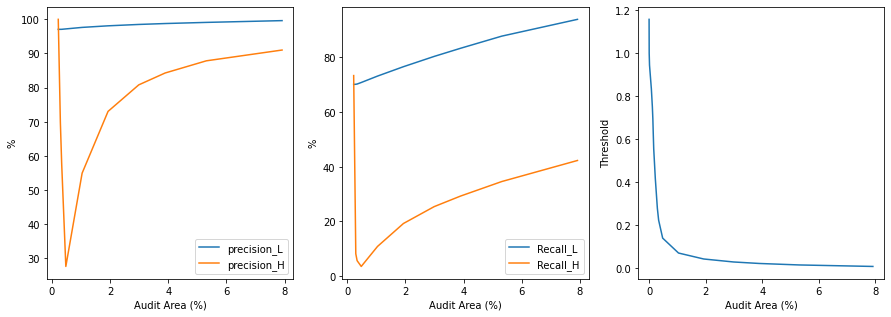

In [449]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, label="precision_L")
ax1.plot(m['AA']*100, m['precision_H']*100, label="precision_H")
ax1.legend(loc="lower right")
ax1.set_ylabel('%')
ax1.set_xlabel('Audit Area (%)')

ax2.plot(m['AA']*100, m['recall_L']*100, label="Recall_L")
ax2.plot(m['AA']*100, m['recall_H']*100, label="Recall_H")
ax2.legend(loc="lower right")
ax2.set_ylabel('%')
ax2.set_xlabel('Audit Area (%)')

ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Threshold')

# if save_figures == True:
if True:
    plt.savefig('output/figures/recall_precision_AA.png', dpi=150, bbox_inches='tight')

In [450]:
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]


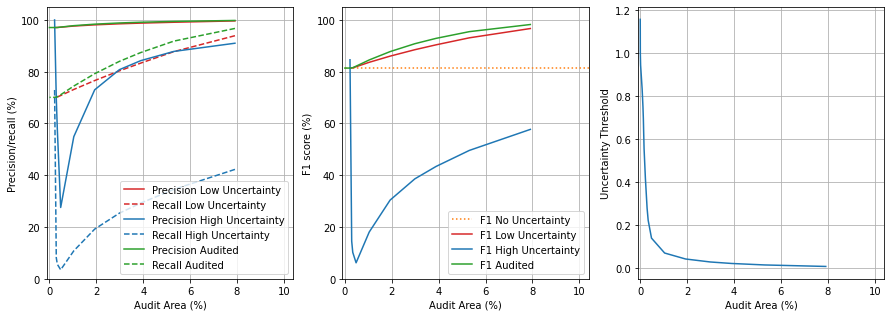

In [451]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.plot(m['AA']*100, m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
ax1.plot(m['AA']*100, m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
ax1.plot(m['AA']*100, m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
ax1.plot(m['AA']*100, m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
ax1.plot(m['AA']*100, m_audited['precision']*100, 'C2-', label="Precision Audited")
ax1.plot(m['AA']*100, m_audited['recall']*100, 'C2--', label="Recall Audited")

ax1.legend(loc="lower right")
ax1.set_ylabel('Precision/recall (%)')
ax1.set_xlabel('Audit Area (%)')
ax1.set_ylim(ylim)
ax1.set_xlim(xlim)
ax1.grid()

# ax2.plot(np.append(0, m['AA']*100), 
#     np.append(f1, np.ones_like(m['AA']) * f1), 
#     'C1:', label="F1 No Uncertainty")
ax2.plot(range(int(xlim[0]), int(xlim[1] + 2)), 
    np.ones(int(xlim[1] + 2)) * f1, 
    'C1:', label="F1 No Uncertainty")



ax2.plot(m['AA']*100, m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
ax2.plot(m['AA']*100, m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
ax2.plot(m['AA']*100, m_audited['f1']*100, 'C2-', label="F1 Audited")

ax2.legend(loc="lower right")
ax2.set_ylabel('F1 score (%)')
ax2.set_xlabel('Audit Area (%)')
ax2.set_ylim(ylim)
ax2.set_xlim(xlim)

ax2.grid()
ax3.plot(m['AA']*100, np.asarray(threshold_list), label="AA")
ax3.set_xlabel('Audit Area (%)')
ax3.set_ylabel('Uncertainty Threshold')
ax3.grid()
ax3.set_xlim(xlim)



# if save_figures == True:
if True:
    plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

In [452]:
np.append(np.append(0, m['AA']*100), 10.5)

array([ 0.        ,  7.91324285,  5.31051147,  3.89344954,  2.98685298,
        1.93128501,  1.04004976,  0.48012107,  0.33781246,  0.29259965,
        0.22001035,  0.16344496,  0.14777542,  0.13302685,  0.11596569,
        0.08077474,  0.015413  ,  0.00374297,  0.00000369,  0.00000185,
       10.5       ])

In [453]:
AA

0.004482172175904481

In [454]:


m

{'precision_L': array([0.99627207, 0.99108186, 0.98774064, 0.98506345, 0.98103887,
        0.97640943, 0.97197581, 0.97082201, 0.97074423, 0.97070479,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'recall_L': array([0.93908337, 0.87766275, 0.83321749, 0.80343026, 0.76585726,
        0.73148805, 0.70798602, 0.70238074, 0.70151069, 0.70096419,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'recall_Ltotal': array([0.50610383, 0.5862217 , 0.6294709 , 0.65367161, 0.67924778,
        0.69567224, 0.70060174, 0.70084201, 0.7008933 , 0.70095   ,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan]),
 'AA': array([0.07913243, 0.05310511, 0.0389345 , 0.02986853, 0.01931285,
        0.0104005 , 0.00480121, 0.00337812, 0.002926  , 0.0022001 ,
        0.00163445, 0.001477

In [455]:
m_audited

{'precision': array([0.99804576, 0.99428836, 0.9911402 , 0.988339  , 0.98370103,
        0.97792637, 0.97237554, 0.97091029, 0.97077985, 0.97070561,
        0.97070539, 0.97070539, 0.97070539, 0.97070539, 0.97070539,
        0.97070539, 0.97070539, 0.97070539, 0.97070539]),
 'recall': array([0.96716997, 0.91828666, 0.8740008 , 0.84007068, 0.79233606,
        0.74463519, 0.71103171, 0.70303275, 0.70177338, 0.70097024,
        0.70096484, 0.70096484, 0.70096484, 0.70096484, 0.70096484,
        0.70096484, 0.70096484, 0.70096484, 0.70096484]),
 'f1': array([0.98236532, 0.95477744, 0.92889206, 0.9081932 , 0.87770892,
        0.84548315, 0.82141721, 0.81553758, 0.81464367, 0.81407618,
        0.81407246, 0.81407246, 0.81407246, 0.81407246, 0.81407246,
        0.81407246, 0.81407246, 0.81407246, 0.81407246])}

In [456]:
# exp

In [457]:
threshold_list

[0.006944444444444445,
 0.01388888888888889,
 0.020833333333333332,
 0.02777777777777778,
 0.041666666666666664,
 0.06944444444444445,
 0.1388888888888889,
 0.22222222222222224,
 0.2777777777777778,
 0.4166666666666667,
 0.5555555555555556,
 0.625,
 0.6944444444444444,
 0.7500000000000001,
 0.8333333333333334,
 0.9444444444444445,
 1.0,
 1.1549454154968262,
 1.1579454154968263]

In [458]:
# threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]


In [459]:
predictor

<Predictor.KL: 4>

In [460]:

importlib.reload(_metrics)


# threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
#         0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003, np.max(uncertainty)-0.0015]
#threshold_list2 = [0.09] # exp 77 PA 50 runs
# threshold_list2 = [0.085] # exp 77 PA 30 runs
# threshold_list2 = [0.085] # exp 77 PA 10 runs
# threshold_list2 = [0.083] # exp 77 PA 5 runs
threshold_list2 = [0.065] # exp 77 PA 5 runs
threshold_list2 = [0.06] # exp 77 PA 5 runs
threshold_list2 = [0.0825] # exp 77 PA 3 runs

if predictor == Predictor.pred_entropy:
        if issubclass(type(dataset), PA):
                threshold_list2 = [0.163]
                threshold_list2 = [0.151]

        elif issubclass(type(dataset), MT):
                threshold_list2 = [0.116]
                threshold_list2 = [0.171]

ic(uncertainty.shape, label_mask_current_deforestation_test.shape)

metrics_values2 = _metrics.getAA_Recall(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)

metric_values_audited2 = _metrics.getUncertaintyMetricsAudited(uncertainty, 
        label_mask_current_deforestation_test, 
        predicted_test, threshold_list2)



ic| uncertainty.shape: (54181542,)
    label_mask_current_deforestation_test.shape: (54181542,)


threshold 0.0825
(53725228,) (53725228,)


ic| label_current_deforestation_test_classified_incorrect.shape: (456314,)
    predicted_test_classified_incorrect.shape: (456314,)
ic| TP_H + FN_H + FP_H + TN_H: 456314
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 456314
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52997286    13212]
 [  197650   517080]]
cm_incorrect [[427738   2460]
 [ 23889   2227]]
[0.97508542 0.72346201 0.69795882 0.00842195 0.47514402 0.0852734 ]
threshold 0.0825
(54181542,) (54181542,)
cm_audited [[53427484    13212]
 [  197650   543196]]
[0.97625483 0.73321041]


In [461]:
m2 = {'precision_L': metrics_values2[:,0],
        'recall_L': metrics_values2[:,1],
        'recall_Ltotal': metrics_values2[:,2],
        'AA': metrics_values2[:,3],
        'precision_H': metrics_values2[:,4],
        'recall_H': metrics_values2[:,5]}

m_audited2 = {'precision': metric_values_audited2[:,0],
        'recall': metric_values_audited2[:,1]}

m2['f1_L'] = 2*m2['precision_L']*m2['recall_L']/(m2['precision_L']+m2['recall_L'])
m2['f1_H'] = 2*m2['precision_H']*m2['recall_H']/(m2['precision_H']+m2['recall_H'])

m_audited2['f1'] = 2*m_audited2['precision']*m_audited2['recall']/(m_audited2['precision']+m_audited2['recall'])

ic(m2)
ic(m_audited2)


ic| m2: {'AA': array([0.00842195]),
         'f1_H': array([0.14459631]),
         'f1_L': array([0.83063592]),
         'precision_H': array([0.47514402]),
         'precision_L': array([0.97508542]),
         'recall_H': array([0.0852734]),
         'recall_L': array([0.72346201]),
         'recall_Ltotal': array([0.69795882])}
ic| m_audited2: {'f1': array([0.83745512]),
                 'precision': array([0.97625483]),
                 'recall': array([0.73321041])}


{'precision': array([0.97625483]),
 'recall': array([0.73321041]),
 'f1': array([0.83745512])}

In [462]:
pred_entropy_unpad = utils_v1.unpadIm(pred_entropy, npad)
ic(pred_entropy_unpad.shape)

threshold_uncertainty = 0.1

uncertainty_mask = np.zeros_like(pred_entropy_unpad).astype(np.int8)
uncertainty_mask[pred_entropy_unpad >= threshold_uncertainty] = 1
ic(np.unique(uncertainty_mask, return_counts=True))


ic| pred_entropy_unpad.shape: (17730, 9200)
ic| np.unique(uncertainty_mask, return_counts=True): (array([0, 1], dtype=int8), array([157393940,   5722060], dtype=int64))


(array([0, 1], dtype=int8), array([157393940,   5722060], dtype=int64))

(-0.5, 9199.5, 17729.5, -0.5)

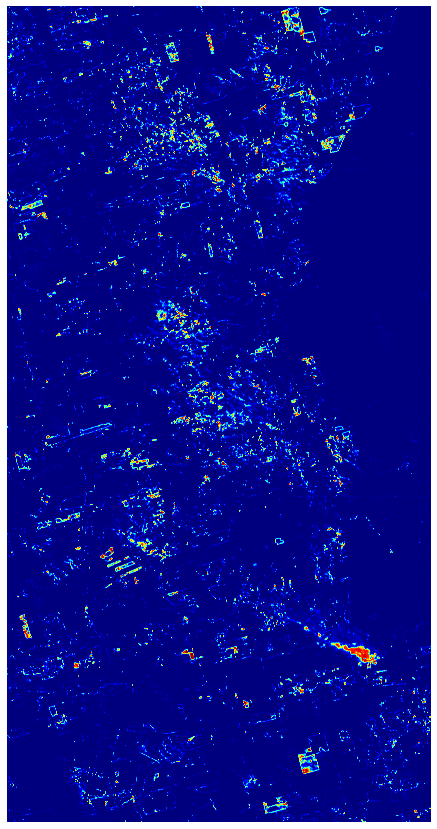

In [463]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

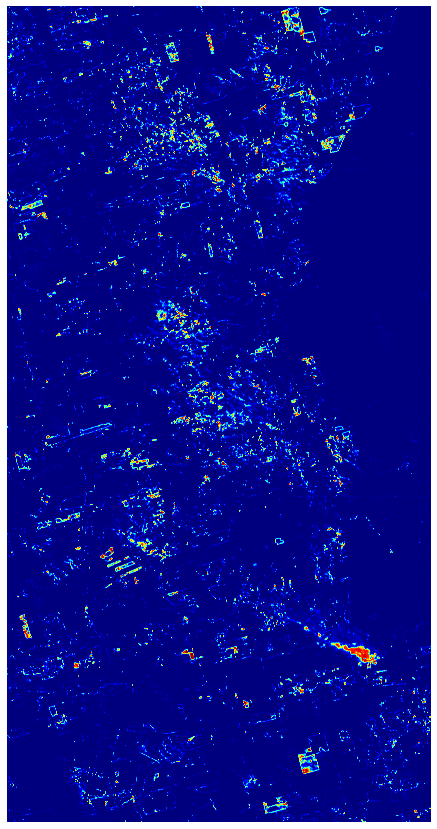

In [464]:

fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(pred_entropy_to_show, cmap='jet')
plt.axis('off')


(-0.5, 9199.5, 17729.5, -0.5)

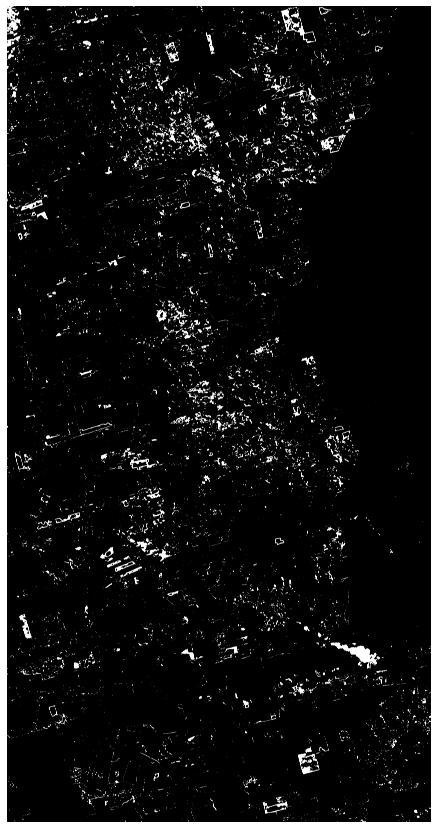

In [465]:
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(uncertainty_mask, cmap=plt.cm.gray)
plt.axis('off')


In [466]:
config = {
	"training": False,
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 10
}

import src.trainer.Trainer as t
importlib.reload(t)
trainer = t.Trainer(config, dataset, patchesHandler)


In [467]:
trainer.uncertainty = uncertainty
trainer.label_mask_current_deforestation_test = label_mask_current_deforestation_test
trainer.predicted_test = predicted_test


In [468]:
trainer.getOptimalUncertaintyThreshold(bound = 0.0015)

ic| bounds: (0.0015, 1.1594454154968261)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.4437957916026683
threshold 0.4437957916026683
(54069249,) (54069249,)


ic| label_current_deforestation_test_classified_incorrect.shape: (112293,)
    predicted_test_classified_incorrect.shape: (112293,)
ic| TP_H + FN_H + FP_H + TN_H: 112293
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 112293
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53312733    15672]
 [  221539   519305]]
cm_incorrect [[112291      0]
 [     0      2]]
[0.97070528 0.70096404 0.70096214 0.00207253 1.         1.        ]
0.7171496238941577
threshold 0.7171496238941577
(54112980,) (54112980,)


ic| label_current_deforestation_test_classified_incorrect.shape: (68562,)
    predicted_test_classified_incorrect.shape: (68562,)
ic| np.all(label_current_deforestation_test_classified_incorrect) == 0: True
ic| np.all(predicted_test_classified_incorrect) == 0: True


cm_correct [[53356462    15672]
 [  221539   519307]]
cm_incorrect [[68562]]
[       nan        nan        nan 0.00126541        nan        nan]
0.27485383229148935
threshold 0.27485383229148935
(54021938,) (54021938,)


ic| label_current_deforestation_test_classified_incorrect.shape: (159604,)
    predicted_test_classified_incorrect.shape: (159604,)
ic| TP_H + FN_H + FP_H + TN_H: 159604
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 159604
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53266128    15647]
 [  220912   519251]]
cm_incorrect [[158896     25]
 [   627     56]]
[0.97074769 0.70153601 0.70088925 0.00294573 0.69135802 0.08199122]
0.170441959311179
threshold 0.170441959311179
(53962097,) (53962097,)


ic| label_current_deforestation_test_classified_incorrect.shape: (219445,)
    predicted_test_classified_incorrect.shape: (219445,)
ic| TP_H + FN_H + FP_H + TN_H: 219445
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 219445
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53209881    15393]
 [  217673   519150]]
cm_incorrect [[215143    279]
 [  3866    157]]
[0.97120344 0.70457898 0.70075292 0.00405018 0.36009174 0.0390256 ]
0.1059118729803104
threshold 0.1059118729803104
(53839747,) (53839747,)


ic| label_current_deforestation_test_classified_incorrect.shape: (341795,)
    predicted_test_classified_incorrect.shape: (341795,)
ic| TP_H + FN_H + FP_H + TN_H: 341795
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 341795
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[53099879    14132]
 [  207123   518613]]
cm_incorrect [[325145   1540]
 [ 14416    694]]
[0.97347324 0.71460283 0.70002808 0.00630833 0.31065354 0.04592985]
0.06603008633086863
threshold 0.06603008633086863
(53581677,) (53581677,)


ic| label_current_deforestation_test_classified_incorrect.shape: (599865,)
    predicted_test_classified_incorrect.shape: (599865,)
ic| TP_H + FN_H + FP_H + TN_H: 599865
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 599865
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52868351    12215]
 [  186395   514716]]
cm_incorrect [[556673   3457]
 [ 35144   4591]]
[0.9768186  0.73414338 0.69476787 0.01107139 0.57045229 0.11554046]
0.04138178664944181
threshold 0.04138178664944181
(53126799,) (53126799,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1054743,)
    predicted_test_classified_incorrect.shape: (1054743,)
ic| TP_H + FN_H + FP_H + TN_H: 1054743
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1054743
    len(label_mask_current_deforestation_test): 54181542


cm_correct [[52460904     9678]
 [  153265   502952]]
cm_incorrect [[964120   5994]
 [ 68274  16355]]
[0.98112089 0.76644159 0.67888873 0.01946683 0.73180008 0.19325527]
0.026148299681426828
threshold 0.026148299681426828
(52465459,) (52465459,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1716083,)
    predicted_test_classified_incorrect.shape: (1716083,)


cm_correct [[51864359     6985]
 [  113251   480864]]


ic| TP_H + FN_H + FP_H + TN_H: 1716083
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1716083
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[1560665    8687]
 [ 108288   38443]]
[0.98568205 0.80937866 0.64907417 0.03167283 0.81568003 0.26199644]
0.016733486968014986
threshold 0.016733486968014986
(51664288,) (51664288,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2517254,)
    predicted_test_classified_incorrect.shape: (2517254,)


cm_correct [[51134737     4834]
 [   74831   449886]]


ic| TP_H + FN_H + FP_H + TN_H: 2517254
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 2517254
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[2290287   10838]
 [ 146708   69421]]
[0.98936928 0.85738789 0.60725981 0.04645962 0.86496218 0.32120169]
0.03043445868848855
threshold 0.03043445868848855
(52705028,) (52705028,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1476514,)
    predicted_test_classified_incorrect.shape: (1476514,)
ic

cm_correct [[52081796     7893]
 [  126249   489090]]
cm_incorrect [[1343228    7779]
 [  95290   30217]]


| TP_H + FN_H + FP_H + TN_H: 1476514
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1476514
    len(label_mask_current_deforestation_test): 54181542


[0.98411817 0.79483017 0.66017769 0.02725124 0.79526792 0.24075948]
0.02413537240787452
threshold 0.02413537240787452
(52330889,) (52330889,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1850653,)
    predicted_test_classified_incorrect.shape: (1850653,)


cm_correct [[51741984     6558]
 [  106301   476046]]


ic| TP_H + FN_H + FP_H + TN_H: 1850653
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1850653
    len(label_mask_current_deforestation_test): 54181542


cm_incorrect [[1683040    9114]
 [ 115238   43261]]
[0.98641122 0.81746107 0.64257079 0.03415652 0.82598568 0.27294179]
0.027758942345201324
threshold 0.027758942345201324
(52562127,) (52562127,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1619415,)
    predicted_test_classified_incorrect.shape: (1619415,)
ic

cm_correct [[51952128     7337]
 [  118434   484228]]
cm_incorrect [[1472896    8335]
 [ 103105   35079]]


| TP_H + FN_H + FP_H + TN_H: 1619415
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1619415
    len(label_mask_current_deforestation_test): 54181542


[0.9850742  0.80348189 0.65361492 0.02988868 0.80801124 0.25385718]
0.028016243657282367
threshold 0.028016243657282367
(52576645,) (52576645,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1604897,)
    predicted_test_classified_incorrect.shape: (1604897,)
ic

cm_correct [[51965303     7406]
 [  119182   484754]]
cm_incorrect [[1459721    8266]
 [ 102357   34553]]


| TP_H + FN_H + FP_H + TN_H: 1604897
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1604897
    len(label_mask_current_deforestation_test): 54181542


[0.98495205 0.8026579  0.65432492 0.02962073 0.80695486 0.25237747]
0.027403912149617213
threshold 0.027403912149617213
(52541462,) (52541462,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1640080,)
    predicted_test_classified_incorrect.shape: (1640080,)
ic

cm_correct [[51933382     7267]
 [  117332   483481]]
cm_incorrect [[1491642    8405]
 [ 104207   35826]]


| TP_H + FN_H + FP_H + TN_H: 1640080
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1640080
    len(label_mask_current_deforestation_test): 54181542


[0.98519199 0.80471128 0.65260661 0.03027009 0.8099749  0.25583969]
0.02767340587906262
threshold 0.02767340587906262
(52557234,) (52557234,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624308,)
    predicted_test_classified_incorrect.shape: (1624308,)
ic

cm_correct [[51947685     7325]
 [  118181   484043]]
cm_incorrect [[1477339    8347]
 [ 103358   35264]]


| TP_H + FN_H + FP_H + TN_H: 1624308
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1624308
    len(label_mask_current_deforestation_test): 54181542


[0.98509264 0.80375907 0.65336521 0.02997899 0.80860333 0.25438964]
0.02762152052398365
threshold 0.02762152052398365
(52554245,) (52554245,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1627297,)
    predicted_test_classified_incorrect.shape: (1627297,)
ic

cm_correct [[51944945     7315]
 [  118032   483953]]
cm_incorrect [[1480079    8357]
 [ 103507   35354]]


| TP_H + FN_H + FP_H + TN_H: 1627297
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1627297
    len(label_mask_current_deforestation_test): 54181542


[0.98510996 0.80392867 0.65324372 0.03003416 0.80881243 0.25459992]
0.027706739622858894
threshold 0.027706739622858894
(52559079,) (52559079,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1622463,)
    predicted_test_classified_incorrect.shape: (1622463,)
ic

cm_correct [[51949345     7329]
 [  118279   484126]]
cm_incorrect [[1475679    8343]
 [ 103260   35181]]


| TP_H + FN_H + FP_H + TN_H: 1622463
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1622463
    len(label_mask_current_deforestation_test): 54181542
ic| self.threshold_optimal: 0.02767340587906262


[0.98508714 0.80365535 0.65347724 0.02994494 0.80831266 0.25412269]


In [469]:
trainer.threshold_optimal

0.02767340587906262

In [470]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.02767340587906262
(52557234,) (52557234,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624308,)
    predicted_test_classified_incorrect.shape: (1624308,)
ic

cm_correct [[51947685     7325]
 [  118181   484043]]
cm_incorrect [[1477339    8347]
 [ 103358   35264]]


| TP_H + FN_H + FP_H + TN_H: 1624308
    len(label_mask_current_deforestation_test): 54181542
ic| TP_H + FN_H + FP_H + TN_H: 1624308
    len(label_mask_current_deforestation_test): 54181542


[0.98509264 0.80375907 0.65336521 0.02997899 0.80860333 0.25438964]
threshold 0.02767340587906262
(54181542,) (54181542,)


ic| self.m_optimal: {'AA': array([0.02997899]),
                     'f1_H': array([0.38702101]),
                     'f1_L': array([0.88523508]),
                     'precision_H': array([0.80860333]),
                     'precision_L': array([0.98509264]),
                     'recall_H': array([0.25438964]),
                     'recall_L': array([0.80375907]),
                     'recall_Ltotal': array([0.65336521])}
ic| self.m_audited_optimal: {'f1': array([0.90844565]),
                             'precision': array([0.98837283]),
                             'recall': array([0.84047832])}


cm_audited [[53433371     7325]
 [  118181   622665]]
[0.98837283 0.84047832]
